In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [38]:
import random
from numpy.random import seed
random.seed(36)
seed(36)
tf.random.set_seed(36)
np.random.seed(36)
import os
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.utils.set_random_seed(36)
tf.config.experimental.enable_op_determinism()

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
data = pd.read_csv('diabetes.csv')
print(data.shape)
data.head(3)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [42]:
df = data.drop(['Outcome'], axis=1)
df.shape

(768, 8)

### K-means

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

In [44]:
def silhouette_kmeans_plot(X, K, Model):
    score_list = []
    inertia_list = []
    time_list = []
    K = range(2, K+1)
    for k in K:
        start = time.time()
        model= Model(k, random_state=36)
        model.fit(X.values)
        inertia_list.append(model.inertia_)
        score = silhouette_score(X, model.labels_)
        score_list.append(score)
        end = time.time()
        time_list.append(end-start)
        # print('K =', k, 'Silhouette Score =', score, 'Inertia =', model.inertia_, 'Time =', end-start)
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].plot(K, score_list, 'bo-')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Silhouette Score')
    ax[0].set_title('Silhouette Score vs. Number of Clusters')
    ax[0].set_xticks(np.arange(2, K[-1]+1, 2))
    ax[1].plot(K, inertia_list, 'ro-')
    ax[1].set_ylabel('Inertia')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_xticks(np.arange(2, K[-1]+1, 2))
    ax[1].set_title('Silhouette Inertia vs. Number of Clusters')
    ax[2].plot(K, time_list, 'go-')
    ax[2].set_ylabel('Time')
    ax[2].set_xlabel('Number of Clusters (k)')
    ax[2].set_xticks(np.arange(2, K[-1]+1, 2))
    ax[2].set_title('Silhouette Time vs. Number of Clusters')
    plt.show()


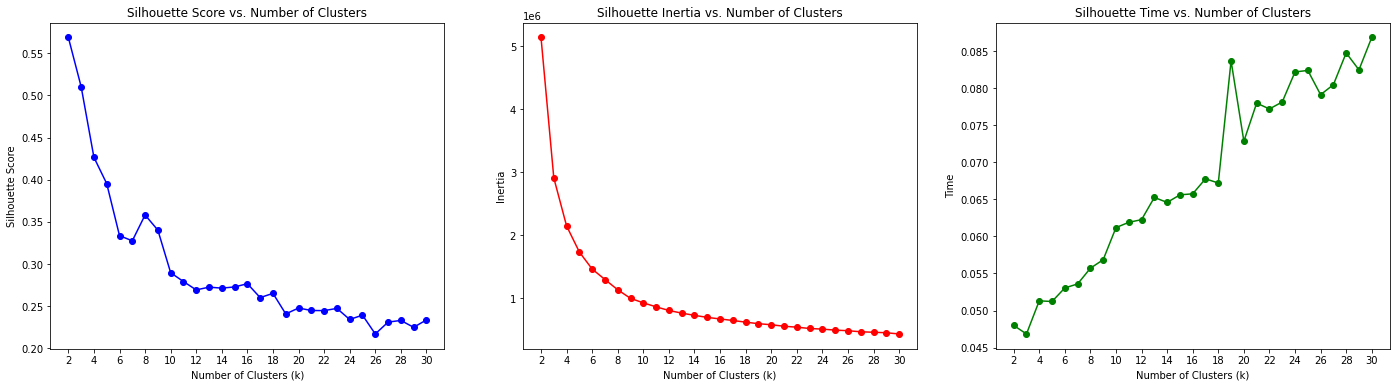

In [45]:
silhouette_kmeans_plot(df, 30, KMeans)

In [46]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance

In [47]:
def SV_ICD_plots(X, K, Model):
    plot_nums = len(K)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    row = 0
    for k in K:
        kmeans = Model(n_clusters=k, random_state=36)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[row][0])
        visualizer.fit(X.values)
        visualizer.finalize()
        
        kmeans = Model(n_clusters=k, random_state=36)
        visualizer = InterclusterDistance(kmeans, ax=axes[row][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        row+=1
    plt.show()

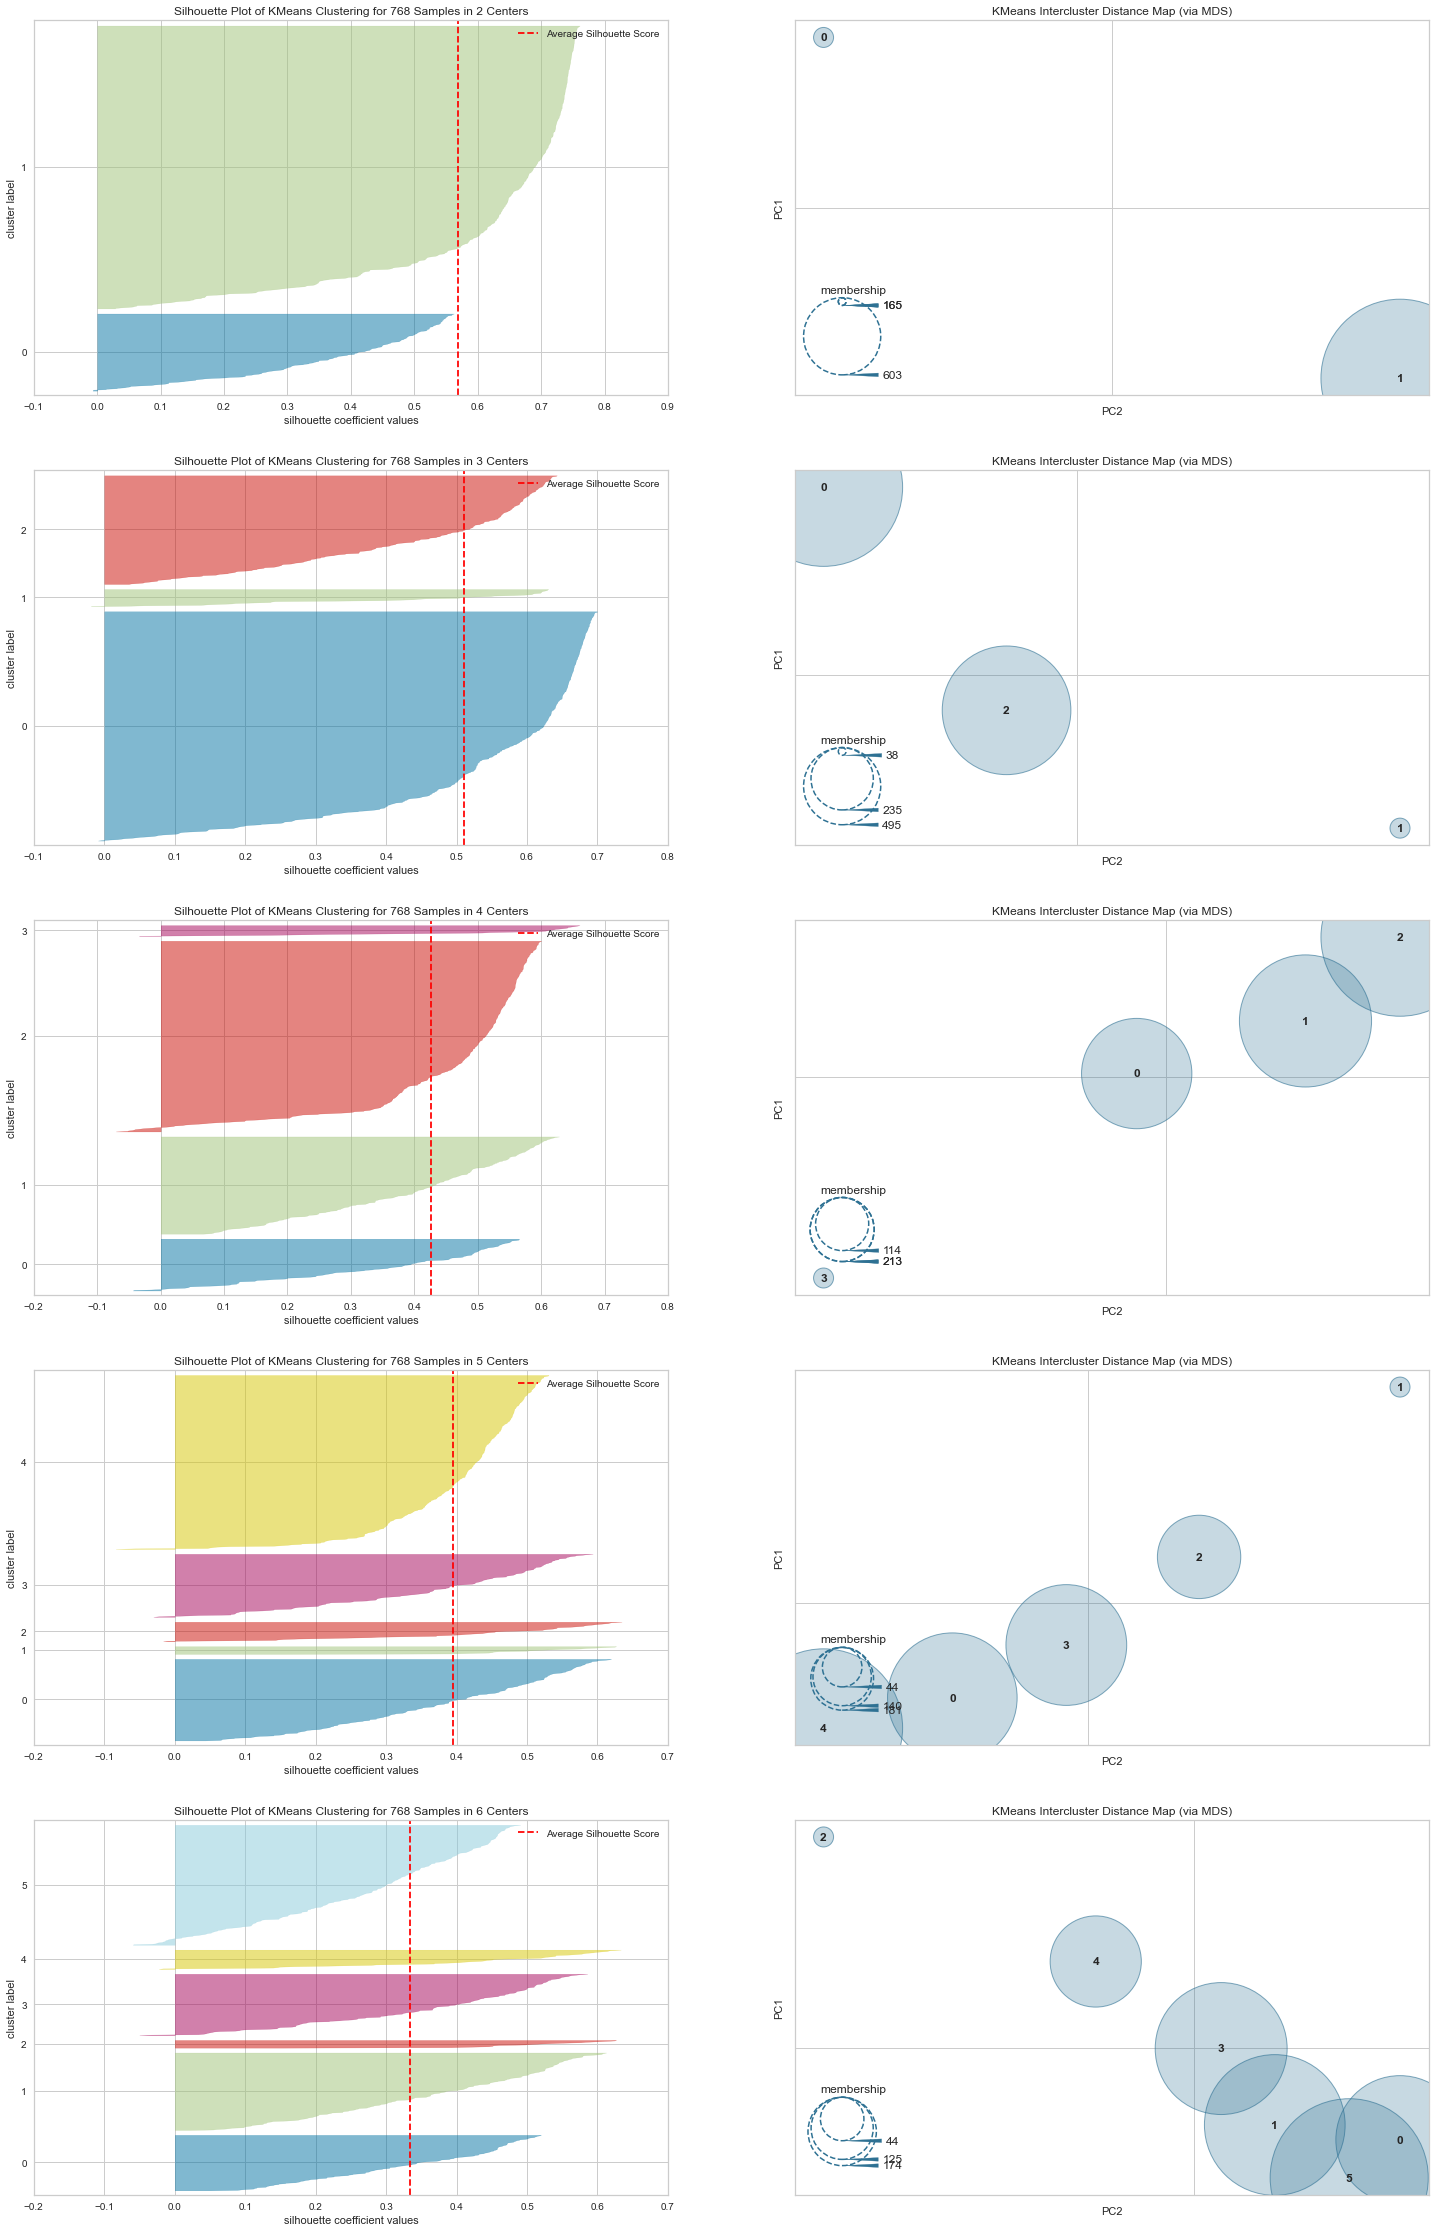

In [48]:
K = [2, 3, 4, 5, 6]
SV_ICD_plots(df, K, KMeans)

### Expected Maximization (GMM)

In [49]:
from sklearn.mixture import GaussianMixture

In [50]:
def silhouette_gmm_plot(X, K, Model):
    score_list = []
    time_list = []
    K = range(2, K+1)
    for k in K:
        start = time.time()
        model= Model(k, random_state=36, n_init=9)
        model.fit(X.values)
        score = silhouette_score(X, model.predict(X.values))
        score_list.append(score)
        end = time.time()
        time_list.append(end-start)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(K, score_list, 'bo-')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Silhouette Score')
    ax[0].set_title('Silhouette Score vs. Number of Clusters')
    ax[0].set_xticks(np.arange(2, K[-1]+1, 2))
    ax[1].plot(K, time_list, 'ro-')
    ax[1].set_ylabel('Time')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_xticks(np.arange(2, K[-1]+1, 2))
    ax[1].set_title('Silhouette Time vs. Number of Clusters')
    plt.show()

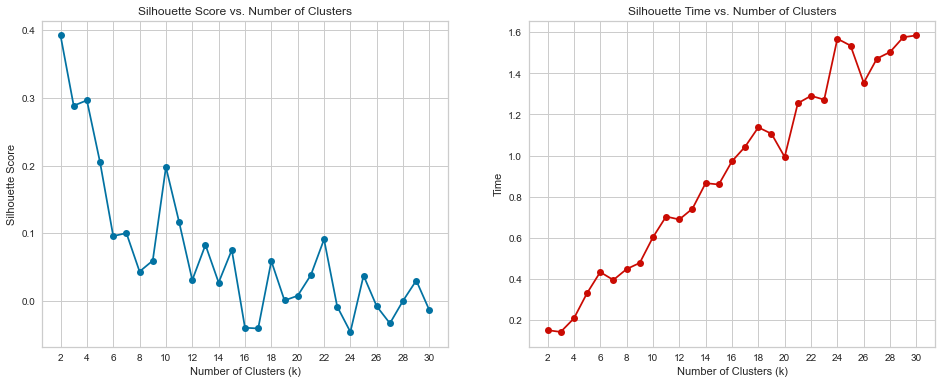

In [51]:
silhouette_gmm_plot(df, 30, GaussianMixture)

In [52]:
def aic_bic_plot(X, K, Model):
    aic = []
    bic = []
    time_list = []
    K = range(2, K+1)
    for k in K:
        start = time.time()
        gmm = Model(n_components=k, random_state=36, n_init=9).fit(X.to_numpy())
        end = time.time()
        time_list.append(end-start)
        aic.append(gmm.aic(X.to_numpy()))
        bic.append(gmm.bic(X.to_numpy()))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(K, aic, 'bo-', label='AIC')
    ax.plot(K, bic, 'ro-', label='BIC')
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('AIC/BIC')
    ax.set_title('AIC/BIC vs. Number of Clusters')
    ax.set_xticks(np.arange(2, K[-1]+1, 2))
    ax.legend()
    plt.show()


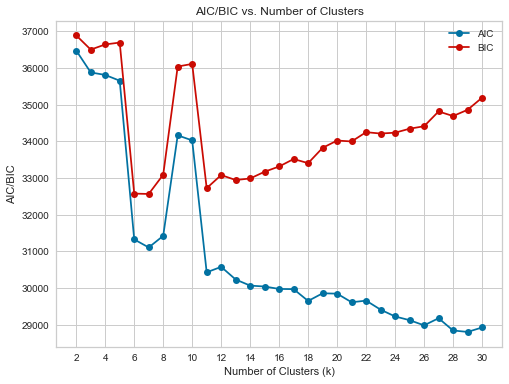

In [53]:
aic_bic_plot(df, 30, GaussianMixture)

### PCA

In [54]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

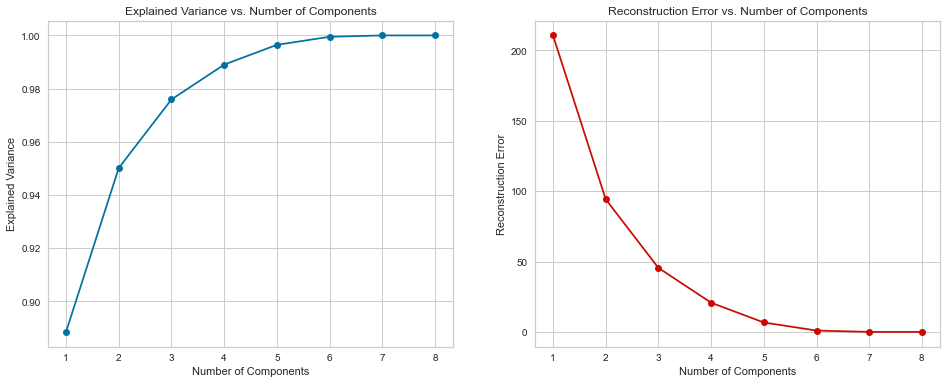

In [55]:
variance_pca = []
error_pca = []
for i in range(1, len(df.columns)+1):
    pca = PCA(n_components=i, random_state=36)
    pca.fit(df.to_numpy())
    variance_pca.append(np.sum(pca.explained_variance_ratio_))
    
    X_reduced = pca.transform(df.to_numpy())
    X_project = pca.inverse_transform(X_reduced)
    error_pca.append(mean_squared_error(df.values, X_project))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(range(1, len(df.columns)+1), variance_pca, 'bo-')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance')
ax[0].set_title('Explained Variance vs. Number of Components')
ax[0].set_xticks(np.arange(1, len(df.columns)+1, 1))
ax[1].plot(range(1, len(df.columns)+1), error_pca, 'ro-')
ax[1].set_ylabel('Reconstruction Error')
ax[1].set_xlabel('Number of Components')
ax[1].set_title('Reconstruction Error vs. Number of Components')
ax[1].set_xticks(np.arange(1, len(df.columns)+1, 1))
plt.show()


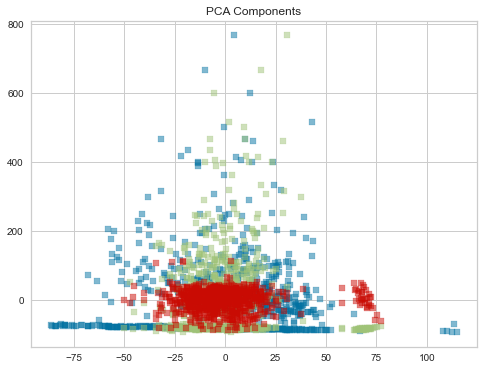

In [56]:
i = 3
pca = PCA(n_components=i)
X_reduced = pca.fit_transform(df.to_numpy())

plt.figure(figsize=(8,6))
plt.title('PCA Components')

for i in range(0, i):
    for j in range(0, i):
        if i == j:
            continue
        plt.scatter(X_reduced[:,i], X_reduced[:,j], marker='s', s=30, alpha=0.5)


### ICA

In [57]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

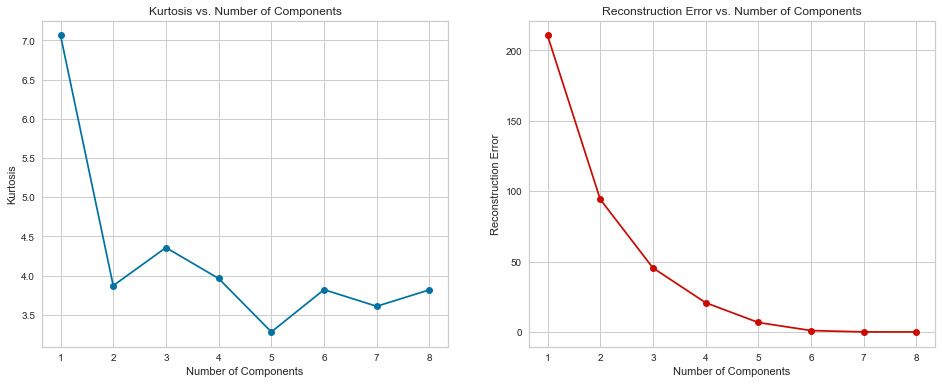

In [58]:
kurtosis_ica = []
error_ica = []
for i in range(1, len(df.columns)+1):
    ica = FastICA(n_components=i, random_state=36, max_iter=600)
    ica.fit(df.to_numpy())
    
    X_reduced = ica.transform(df.to_numpy())
    kurtosis_ica.append(np.mean(np.abs(kurtosis(X_reduced))))
    
    X_project = ica.inverse_transform(X_reduced)
    error_ica.append(mean_squared_error(df.values,  X_project))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(range(1, len(df.columns)+1), kurtosis_ica, 'bo-')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Kurtosis')
ax[0].set_title('Kurtosis vs. Number of Components')
ax[0].set_xticks(np.arange(1, len(df.columns)+1, 1))
ax[1].plot(range(1, len(df.columns)+1), error_ica, 'ro-')
ax[1].set_ylabel('Reconstruction Error')
ax[1].set_xlabel('Number of Components')
ax[1].set_title('Reconstruction Error vs. Number of Components')
ax[1].set_xticks(np.arange(1, len(df.columns)+1, 1))
plt.show()

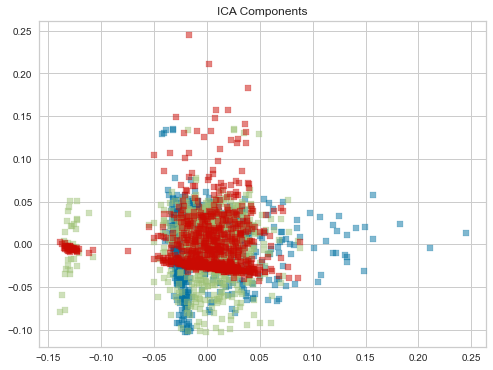

In [59]:
i = 3
ica = FastICA(n_components=i, max_iter=600, random_state=36) 
X_reduced=ica.fit_transform(df.to_numpy())

plt.figure(figsize=(8,6))
plt.title('ICA Components')

for i in range(0, i):
    for j in range(0, i):
        if i == j:
            continue
        plt.scatter(X_reduced[:,i], X_reduced[:,j], marker='s', s=30, alpha=0.5)

### Randomized Projections (RP)

In [60]:
from sklearn import random_projection
from sklearn.metrics import mean_squared_error
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

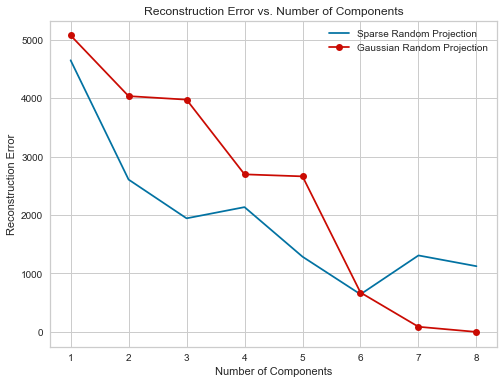

In [61]:
error_RP_SRP = []
for i in range(1, len(df.columns)+1):
    rand_proj = SparseRandomProjection(n_components=i, compute_inverse_components=True, random_state=36)
    rand_proj.fit(df.to_numpy())
    X_reduced = rand_proj.transform(df.values)   
    X_recon = rand_proj.inverse_transform(X_reduced)
    error_RP_SRP.append(mean_squared_error(df.to_numpy(), X_recon))

error_RP_GRP = []
for i in range(1, len(df.columns)+1):
    rand_proj = GaussianRandomProjection(n_components=i, compute_inverse_components=True, random_state=36)
    rand_proj.fit(df.to_numpy())
    X_reduced = rand_proj.transform(df.values)   
    X_recon = rand_proj.inverse_transform(X_reduced)
    error_RP_GRP.append(mean_squared_error(df.to_numpy(), X_recon))

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(df.columns)+1), error_RP_SRP, 'bx-', label='Sparse Random Projection')
plt.plot(range(1, len(df.columns)+1), error_RP_GRP, 'ro-', label='Gaussian Random Projection')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Components')
plt.legend()
plt.show()

### Dictionary Learning (DL)

In [62]:
from sklearn.decomposition import DictionaryLearning

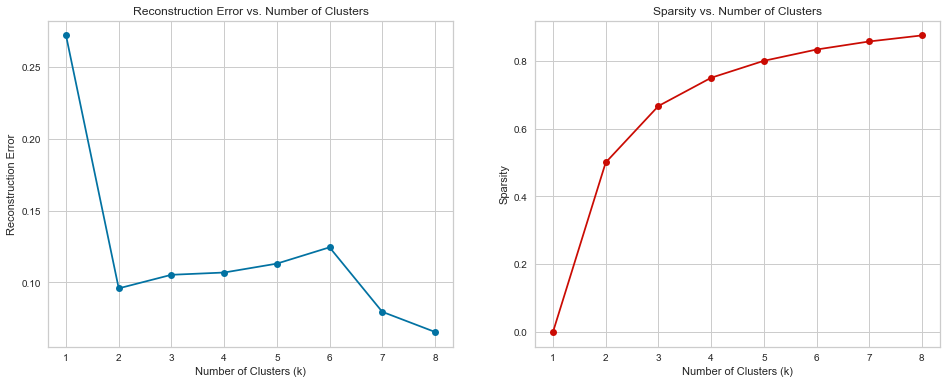

In [63]:
error_DL=[]
sparsity_DL=[]
for i in range(1, len(df.columns)+1):
    dict_learner = DictionaryLearning(n_components=i, random_state=36, fit_algorithm='lars', transform_algorithm='omp')
    X_transformed = dict_learner.fit_transform(df.values)
    X_hat = X_transformed@dict_learner.components_
    loss = np.mean(np.sum((X_hat-df.values)**2, axis=1)/np.sum(df.values**2, axis=1))
    error_DL.append(loss)
    sparsity_DL.append(np.mean(X_transformed==0))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(range(1, len(df.columns)+1), error_DL, 'bo-')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Reconstruction Error')
ax[0].set_title('Reconstruction Error vs. Number of Clusters')
ax[1].plot(range(1, len(df.columns)+1), sparsity_DL, 'ro-')
ax[1].set_ylabel('Sparsity')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_title('Sparsity vs. Number of Clusters')
plt.show()

### Clustering with Dimension Reduction

In [64]:
#pca
start = time.time()
pca = PCA(n_components=3, random_state=36)
end = time.time()
df_pca = pd.DataFrame(pca.fit_transform(df.values))
time_pca = end-start

#ICA
start = time.time()
ica = FastICA(n_components=3, random_state=36)
end = time.time()
df_ica = pd.DataFrame(ica.fit_transform(df.values))
time_ica = end-start

#RP
start = time.time()
rp = SparseRandomProjection(n_components=3, random_state=36)
end = time.time()
df_rp = pd.DataFrame(rp.fit_transform(df.values))
time_rp = end-start

#DL
start = time.time()
dl = DictionaryLearning(n_components=2, random_state=36, fit_algorithm='lars', transform_algorithm='omp')
end = time.time()
df_dl = pd.DataFrame(dl.fit_transform(df.values))
time_dl = end-start

In [65]:
# plt.figure(figsize=(8, 6))
# plt.bar(['PCA', 'ICA', 'RP', 'DL'], [time_pca, time_ica, time_rp, time_dl])
# plt.ylabel('Time (s)')
# plt.title('Time to Fit Models')
# plt.show()

In [66]:
# Kmeans
score_list_pca = []
inertia_list_pca = []
time_list_pca = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= KMeans(k, random_state=36)
    model.fit(df_pca.values)
    inertia_list_pca.append(model.inertia_)
    score = silhouette_score(df_pca.values, model.labels_)
    score_list_pca.append(score)
    end = time.time()
    time_list_pca.append(end-start)


score_list_ica = []
inertia_list_ica = []
time_list_ica = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= KMeans(k, random_state=36)
    model.fit(df_ica.values)
    inertia_list_ica.append(model.inertia_)
    score = silhouette_score(df_ica.values, model.labels_)
    score_list_ica.append(score)
    end = time.time()
    time_list_ica.append(end-start)

score_list_rp = []
inertia_list_rp = []
time_list_rp = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= KMeans(k, random_state=36)
    model.fit(df_rp.values)
    inertia_list_rp.append(model.inertia_)
    score = silhouette_score(df_rp.values, model.labels_)
    score_list_rp.append(score)
    end = time.time()
    time_list_rp.append(end-start)

score_list_dl = []
inertia_list_dl = []
time_list_dl = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= KMeans(k, random_state=36)
    model.fit(df_dl.values)
    inertia_list_dl.append(model.inertia_)
    score = silhouette_score(df_dl.values, model.labels_)
    score_list_dl.append(score)
    end = time.time()
    time_list_dl.append(end-start)

score_list_orig = []
inertia_list_orig = []
time_list_orig = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= KMeans(k, random_state=36)
    model.fit(df.values)
    inertia_list_orig.append(model.inertia_)
    score = silhouette_score(df.values, model.labels_)
    score_list_orig.append(score)
    end = time.time()
    time_list_orig.append(end-start)

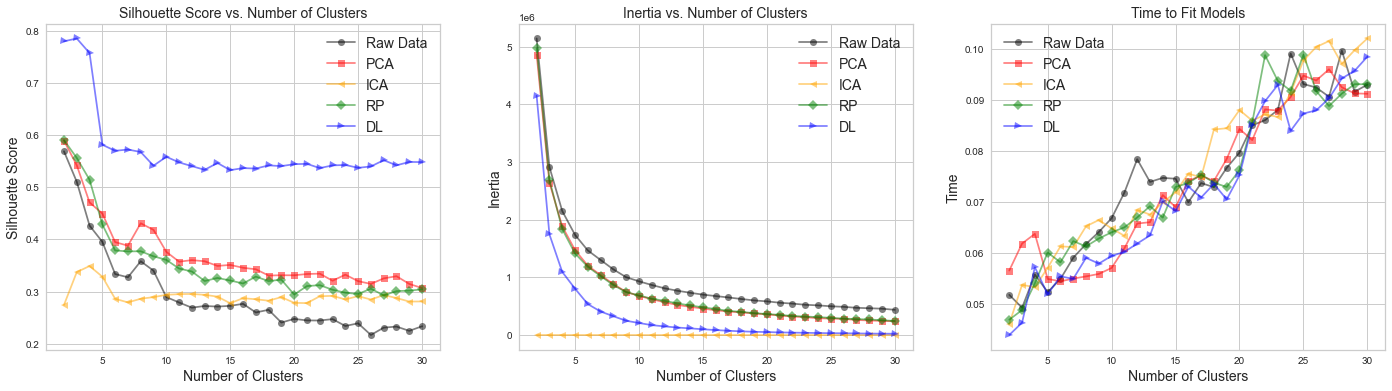

In [67]:
fig, ax = plt.subplots(1, 3,figsize=(24, 6))
ax[0].plot(range(2,31),score_list_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[0].plot(range(2,31),score_list_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[0].plot(range(2,31),score_list_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[0].plot(range(2,31),score_list_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[0].plot(range(2,31),score_list_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[0].set_xlabel('Number of Clusters', fontsize=14)
ax[0].set_ylabel('Silhouette Score', fontsize=14)
ax[0].set_title('Silhouette Score vs. Number of Clusters', fontsize=14)
ax[0].legend(loc='best', fontsize=14)
ax[1].plot(range(2,31),inertia_list_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[1].plot(range(2,31),inertia_list_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[1].plot(range(2,31),inertia_list_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[1].plot(range(2,31),inertia_list_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[1].plot(range(2,31),inertia_list_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[1].set_xlabel('Number of Clusters', fontsize=14)
ax[1].set_ylabel('Inertia', fontsize=14)
ax[1].set_title('Inertia vs. Number of Clusters', fontsize=14)
ax[1].legend(loc='best', fontsize=14)
ax[2].plot(range(2,31),time_list_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[2].plot(range(2,31),time_list_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[2].plot(range(2,31),time_list_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[2].plot(range(2,31),time_list_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[2].plot(range(2,31),time_list_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[2].set_xlabel('Number of Clusters', fontsize=14)
ax[2].set_ylabel('Time', fontsize=14)
ax[2].set_title('Time to Fit Models', fontsize=14)
ax[2].legend(loc='best', fontsize=14)
plt.show()

In [68]:
# K = [2, 3, 4, 5, 6]
# SV_ICD_plots(df_pca, K, KMeans)

In [69]:
# K = [2, 3, 4, 5, 6]
# SV_ICD_plots(df_ica, K, KMeans)

In [70]:
# GMM
score_list_pca = []
bic_pca = []
time_list_pca = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= GaussianMixture(k, random_state=36, n_init=9)
    model.fit(df_pca.values)
    score = silhouette_score(df_pca.values, model.predict(df_pca.values))
    score_list_pca.append(score)
    bic_pca.append(model.bic(df_pca.values))
    end = time.time()
    time_list_pca.append(end-start)


score_list_ica = []
bic_ica = []
time_list_ica = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= GaussianMixture(k, random_state=36, n_init=9)
    model.fit(df_ica.values)
    score = silhouette_score(df_ica.values, model.predict(df_ica.values))
    score_list_ica.append(score)
    bic_ica.append(model.bic(df_ica.values))
    end = time.time()
    time_list_ica.append(end-start)

score_list_rp = []
bic_rp = []
time_list_rp = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= GaussianMixture(k, random_state=36, n_init=9)
    model.fit(df_rp.values)
    score = silhouette_score(df_rp.values, model.predict(df_rp.values))
    score_list_rp.append(score)
    bic_rp.append(model.bic(df_rp.values))
    end = time.time()
    time_list_rp.append(end-start)

score_list_dl = []
bic_dl = []
time_list_dl = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= GaussianMixture(k, random_state=36, n_init=9)
    model.fit(df_dl.values)
    score = silhouette_score(df_dl.values, model.predict(df_dl.values))
    score_list_dl.append(score)
    bic_dl.append(model.bic(df_dl.values))
    end = time.time()
    time_list_dl.append(end-start)

score_list_orig = []
bic_orig = []
time_list_orig = []
K = range(2, 31)
for k in K:
    start = time.time()
    model= GaussianMixture(k, random_state=36, n_init=9)
    model.fit(df.values)
    score = silhouette_score(df.values, model.predict(df.values))
    score_list_orig.append(score)
    bic_orig.append(model.bic(df.values))
    end = time.time()
    time_list_orig.append(end-start)

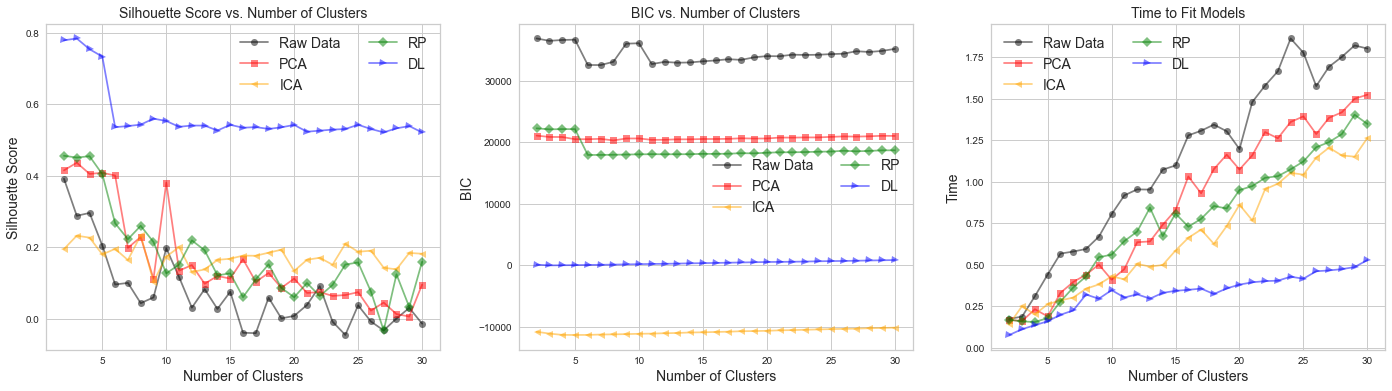

In [71]:
fig, ax = plt.subplots(1, 3,figsize=(24, 6))
ax[0].plot(range(2,31),score_list_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[0].plot(range(2,31),score_list_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[0].plot(range(2,31),score_list_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[0].plot(range(2,31),score_list_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[0].plot(range(2,31),score_list_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[0].set_xlabel('Number of Clusters', fontsize=14)
ax[0].set_ylabel('Silhouette Score', fontsize=14)
ax[0].set_title('Silhouette Score vs. Number of Clusters', fontsize=14)
ax[0].legend(loc='best', fontsize=14, ncol=2)
ax[1].plot(range(2,31),bic_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[1].plot(range(2,31),bic_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[1].plot(range(2,31),bic_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[1].plot(range(2,31),bic_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[1].plot(range(2,31),bic_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[1].set_xlabel('Number of Clusters', fontsize=14)
ax[1].set_ylabel('BIC', fontsize=14)
ax[1].set_title('BIC vs. Number of Clusters', fontsize=14)
ax[1].legend(loc='best', fontsize=14, ncol=2)
ax[2].plot(range(2,31),time_list_orig, color='black', marker='o', alpha=0.5, label='Raw Data')
ax[2].plot(range(2,31),time_list_pca, color='red', marker='s', alpha=0.5, label='PCA')
ax[2].plot(range(2,31),time_list_ica, color='orange', marker='<', alpha=0.5, label='ICA')
ax[2].plot(range(2,31),time_list_rp, color='green', marker='D', alpha=0.5, label='RP')
ax[2].plot(range(2,31),time_list_dl, color='blue', marker='>', alpha=0.5, label='DL')
ax[2].set_xlabel('Number of Clusters', fontsize=14)
ax[2].set_ylabel('Time', fontsize=14)
ax[2].set_title('Time to Fit Models', fontsize=14)
ax[2].legend(loc='best', fontsize=14, ncol=2)
plt.show()

### Neural Network + Dimension Reduction

In [72]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [73]:
data_orig = pd.concat([df, data['Outcome']], axis=1)
data_pca = pd.concat([df_pca, data['Outcome']], axis=1)
data_ica = pd.concat([df_ica, data['Outcome']], axis=1)
data_rp = pd.concat([df_rp, data['Outcome']], axis=1)
data_dl = pd.concat([df_dl, data['Outcome']], axis=1)
print(data_orig.shape, data_pca.shape, data_ica.shape, data_rp.shape, data_dl.shape)

(768, 9) (768, 4) (768, 4) (768, 4) (768, 3)


In [74]:
def ann_model(data):
    X = data.drop('Outcome', axis=1)
    y = data['Outcome'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=36, stratify=y)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    model = Sequential()
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.optimizer.lr = 0.05
    start = time.time()
    model.fit(x=X_train_s, y=y_train, batch_size=32, epochs=20, verbose=2)
    end = time.time()
    print('Time to fit model: ', end-start)
    y_pred = model.predict(X_test_s)
    prediction  = [1 if y>=0.5 else 0 for y in y_pred]
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, prediction)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, prediction))
    print('\n')
    print("Classfication Report:")
    print(classification_report(y_test, prediction)) 

In [75]:
ann_model(data_orig)

Epoch 1/20
17/17 - 2s - loss: 0.5708 - accuracy: 0.7058 - 2s/epoch - 142ms/step
Epoch 2/20
17/17 - 0s - loss: 0.4862 - accuracy: 0.7933 - 75ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.4490 - accuracy: 0.7840 - 81ms/epoch - 5ms/step
Epoch 4/20
17/17 - 0s - loss: 0.4686 - accuracy: 0.7877 - 82ms/epoch - 5ms/step
Epoch 5/20
17/17 - 0s - loss: 0.4436 - accuracy: 0.7933 - 70ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.4392 - accuracy: 0.7933 - 66ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.4306 - accuracy: 0.7970 - 77ms/epoch - 5ms/step
Epoch 8/20
17/17 - 0s - loss: 0.4416 - accuracy: 0.8045 - 54ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.4291 - accuracy: 0.7952 - 57ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.4281 - accuracy: 0.8026 - 60ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.4274 - accuracy: 0.7933 - 55ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.4047 - accuracy: 0.8045 - 54ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.4313

In [76]:
ann_model(data_pca)

Epoch 1/20
17/17 - 0s - loss: 0.5853 - accuracy: 0.7095 - 309ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5477 - accuracy: 0.7486 - 57ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5147 - accuracy: 0.7672 - 56ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5230 - accuracy: 0.7616 - 57ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5295 - accuracy: 0.7579 - 54ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5093 - accuracy: 0.7635 - 65ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5085 - accuracy: 0.7598 - 64ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5062 - accuracy: 0.7747 - 64ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5071 - accuracy: 0.7616 - 72ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5056 - accuracy: 0.7672 - 68ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5062 - accuracy: 0.7561 - 58ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.4996 - accuracy: 0.7542 - 56ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.50

In [77]:
ann_model(data_ica)

Epoch 1/20
17/17 - 0s - loss: 0.5970 - accuracy: 0.6927 - 448ms/epoch - 26ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5490 - accuracy: 0.7505 - 55ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5142 - accuracy: 0.7709 - 58ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5187 - accuracy: 0.7691 - 56ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5202 - accuracy: 0.7542 - 57ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5138 - accuracy: 0.7579 - 66ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5141 - accuracy: 0.7691 - 58ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5052 - accuracy: 0.7635 - 82ms/epoch - 5ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5055 - accuracy: 0.7709 - 62ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5140 - accuracy: 0.7616 - 61ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5156 - accuracy: 0.7579 - 60ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5143 - accuracy: 0.7449 - 57ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.52

In [78]:
ann_model(data_rp)

Epoch 1/20
17/17 - 0s - loss: 0.5862 - accuracy: 0.7002 - 341ms/epoch - 20ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5448 - accuracy: 0.7449 - 66ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5206 - accuracy: 0.7542 - 65ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5237 - accuracy: 0.7579 - 62ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5110 - accuracy: 0.7561 - 62ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5012 - accuracy: 0.7654 - 60ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5206 - accuracy: 0.7523 - 61ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5133 - accuracy: 0.7579 - 64ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.4983 - accuracy: 0.7579 - 65ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5066 - accuracy: 0.7672 - 65ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.4949 - accuracy: 0.7505 - 80ms/epoch - 5ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5120 - accuracy: 0.7467 - 67ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.51

In [79]:
ann_model(data_dl)

Epoch 1/20
17/17 - 0s - loss: 0.6346 - accuracy: 0.6834 - 312ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5797 - accuracy: 0.6983 - 61ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5735 - accuracy: 0.6853 - 65ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5780 - accuracy: 0.6872 - 62ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5796 - accuracy: 0.6760 - 60ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5746 - accuracy: 0.6685 - 61ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5672 - accuracy: 0.6890 - 62ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5655 - accuracy: 0.6872 - 53ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5626 - accuracy: 0.6872 - 55ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5712 - accuracy: 0.7058 - 58ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5616 - accuracy: 0.6890 - 56ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5755 - accuracy: 0.6965 - 62ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.57

### Neural Network + Cluster

In [80]:
# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=36)
kmeans.fit(df.values)
data_orig['Cluster'] = kmeans.labels_
data_pca['Cluster'] = kmeans.labels_
data_ica['Cluster'] = kmeans.labels_
data_rp['Cluster'] = kmeans.labels_
data_dl['Cluster'] = kmeans.labels_

In [81]:
print(data_orig.shape, data_pca.shape, data_ica.shape, data_rp.shape, data_dl.shape)

(768, 10) (768, 5) (768, 5) (768, 5) (768, 4)


In [82]:
ann_model(data_orig)

Epoch 1/20
17/17 - 0s - loss: 0.5625 - accuracy: 0.7039 - 306ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.4804 - accuracy: 0.7747 - 57ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.4506 - accuracy: 0.7896 - 56ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.4543 - accuracy: 0.7821 - 60ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.4246 - accuracy: 0.7914 - 59ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.4301 - accuracy: 0.7765 - 58ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.4253 - accuracy: 0.7803 - 59ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.4067 - accuracy: 0.7858 - 57ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.3991 - accuracy: 0.7970 - 59ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.4017 - accuracy: 0.8026 - 65ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.4303 - accuracy: 0.7952 - 68ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.4130 - accuracy: 0.7933 - 79ms/epoch - 5ms/step
Epoch 13/20
17/17 - 0s - loss: 0.41

In [83]:
data_pca.columns = data_pca.columns.astype(str)
ann_model(data_pca)

Epoch 1/20
17/17 - 0s - loss: 0.5850 - accuracy: 0.6983 - 297ms/epoch - 17ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5436 - accuracy: 0.7374 - 61ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5238 - accuracy: 0.7598 - 55ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5209 - accuracy: 0.7579 - 56ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5250 - accuracy: 0.7486 - 58ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5138 - accuracy: 0.7654 - 57ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5151 - accuracy: 0.7616 - 59ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.4992 - accuracy: 0.7672 - 58ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5073 - accuracy: 0.7505 - 53ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.4995 - accuracy: 0.7598 - 53ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5031 - accuracy: 0.7579 - 60ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.4987 - accuracy: 0.7598 - 75ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.51

In [84]:
data_ica.columns = data_ica.columns.astype(str)
ann_model(data_ica)

Epoch 1/20
17/17 - 0s - loss: 0.5818 - accuracy: 0.7114 - 304ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5375 - accuracy: 0.7449 - 64ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5145 - accuracy: 0.7691 - 65ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5205 - accuracy: 0.7579 - 67ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5302 - accuracy: 0.7430 - 63ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5266 - accuracy: 0.7598 - 61ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5219 - accuracy: 0.7654 - 58ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5073 - accuracy: 0.7635 - 56ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5103 - accuracy: 0.7598 - 56ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5050 - accuracy: 0.7709 - 60ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5064 - accuracy: 0.7616 - 53ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5025 - accuracy: 0.7579 - 57ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.51

In [85]:
data_rp.columns = data_rp.columns.astype(str)
ann_model(data_rp)

Epoch 1/20
17/17 - 0s - loss: 0.6038 - accuracy: 0.6685 - 305ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5419 - accuracy: 0.7505 - 67ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5214 - accuracy: 0.7709 - 67ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5242 - accuracy: 0.7579 - 65ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5193 - accuracy: 0.7449 - 62ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5192 - accuracy: 0.7598 - 53ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5190 - accuracy: 0.7635 - 59ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5053 - accuracy: 0.7728 - 56ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5057 - accuracy: 0.7505 - 56ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5145 - accuracy: 0.7654 - 56ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5128 - accuracy: 0.7542 - 56ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5154 - accuracy: 0.7598 - 66ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.52

In [86]:
data_dl.columns = data_dl.columns.astype(str)
ann_model(data_dl)

Epoch 1/20
17/17 - 0s - loss: 0.6305 - accuracy: 0.6480 - 303ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5820 - accuracy: 0.6946 - 60ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5818 - accuracy: 0.6834 - 66ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5798 - accuracy: 0.6853 - 66ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5741 - accuracy: 0.6723 - 59ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5942 - accuracy: 0.6536 - 59ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5775 - accuracy: 0.6965 - 57ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5680 - accuracy: 0.7076 - 52ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5727 - accuracy: 0.6704 - 57ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5679 - accuracy: 0.6965 - 57ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5648 - accuracy: 0.6965 - 57ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5765 - accuracy: 0.6909 - 66ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.58

In [87]:
# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, random_state=36, n_init=9)
gmm.fit(df.values)
data_orig['Cluster'] = gmm.predict(df.values)
gmm.fit(df_pca.values)
data_pca['Cluster'] = gmm.predict(df_pca.values)
gmm.fit(df_ica.values)
data_ica['Cluster'] = gmm.predict(df_ica.values)
gmm.fit(df_rp.values)
data_rp['Cluster'] = gmm.predict(df_rp.values)
gmm.fit(df_dl.values)
data_dl['Cluster'] = gmm.predict(df_dl.values)

In [88]:
print(data_orig.shape, data_pca.shape, data_ica.shape, data_rp.shape, data_dl.shape)

(768, 10) (768, 5) (768, 5) (768, 5) (768, 4)


In [89]:
ann_model(data_orig)

Epoch 1/20
17/17 - 0s - loss: 0.5315 - accuracy: 0.7505 - 299ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.4696 - accuracy: 0.7765 - 62ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.4424 - accuracy: 0.7933 - 56ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.4589 - accuracy: 0.7896 - 65ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.4402 - accuracy: 0.8138 - 76ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.4315 - accuracy: 0.7933 - 69ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.4332 - accuracy: 0.7970 - 68ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.4131 - accuracy: 0.8119 - 65ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.4105 - accuracy: 0.8063 - 58ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.4075 - accuracy: 0.8082 - 55ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.3960 - accuracy: 0.8063 - 53ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.3795 - accuracy: 0.8268 - 58ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.40

In [90]:
data_pca.columns = data_pca.columns.astype(str)
ann_model(data_pca)

Epoch 1/20
17/17 - 0s - loss: 0.5977 - accuracy: 0.6834 - 296ms/epoch - 17ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5370 - accuracy: 0.7430 - 57ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5198 - accuracy: 0.7561 - 65ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5272 - accuracy: 0.7561 - 67ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5272 - accuracy: 0.7561 - 69ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5072 - accuracy: 0.7561 - 64ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5083 - accuracy: 0.7654 - 60ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5043 - accuracy: 0.7635 - 58ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5028 - accuracy: 0.7672 - 57ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5050 - accuracy: 0.7654 - 60ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5109 - accuracy: 0.7505 - 55ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5062 - accuracy: 0.7523 - 52ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.53

In [91]:
data_ica.columns = data_ica.columns.astype(str)
ann_model(data_ica)

Epoch 1/20
17/17 - 0s - loss: 0.5912 - accuracy: 0.7039 - 297ms/epoch - 17ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5473 - accuracy: 0.7374 - 54ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5149 - accuracy: 0.7598 - 54ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5144 - accuracy: 0.7579 - 58ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5185 - accuracy: 0.7598 - 63ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5044 - accuracy: 0.7728 - 65ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5088 - accuracy: 0.7561 - 65ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5008 - accuracy: 0.7691 - 67ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.4978 - accuracy: 0.7784 - 75ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5018 - accuracy: 0.7709 - 74ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5072 - accuracy: 0.7542 - 64ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.4974 - accuracy: 0.7635 - 61ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.50

In [92]:
data_rp.columns = data_rp.columns.astype(str)
ann_model(data_rp)

Epoch 1/20
17/17 - 0s - loss: 0.5965 - accuracy: 0.6965 - 291ms/epoch - 17ms/step
Epoch 2/20
17/17 - 0s - loss: 0.5472 - accuracy: 0.7467 - 59ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5162 - accuracy: 0.7486 - 58ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5187 - accuracy: 0.7561 - 58ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5135 - accuracy: 0.7542 - 60ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5012 - accuracy: 0.7505 - 60ms/epoch - 4ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5171 - accuracy: 0.7579 - 63ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5043 - accuracy: 0.7561 - 68ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.4979 - accuracy: 0.7393 - 63ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5025 - accuracy: 0.7691 - 60ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5161 - accuracy: 0.7616 - 68ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5013 - accuracy: 0.7523 - 68ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.51

In [93]:
data_dl.columns = data_dl.columns.astype(str)
ann_model(data_dl)

Epoch 1/20
17/17 - 0s - loss: 0.6711 - accuracy: 0.6369 - 310ms/epoch - 18ms/step
Epoch 2/20
17/17 - 0s - loss: 0.6005 - accuracy: 0.6574 - 62ms/epoch - 4ms/step
Epoch 3/20
17/17 - 0s - loss: 0.5808 - accuracy: 0.6834 - 66ms/epoch - 4ms/step
Epoch 4/20
17/17 - 0s - loss: 0.5796 - accuracy: 0.6723 - 60ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.5838 - accuracy: 0.6834 - 67ms/epoch - 4ms/step
Epoch 6/20
17/17 - 0s - loss: 0.5737 - accuracy: 0.6778 - 58ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.5630 - accuracy: 0.6853 - 70ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.5659 - accuracy: 0.6965 - 57ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.5656 - accuracy: 0.7002 - 59ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.5676 - accuracy: 0.6909 - 67ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.5538 - accuracy: 0.6816 - 65ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.5640 - accuracy: 0.6983 - 62ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.57